In [2]:
from model_complex import Calibration
import matplotlib.pyplot as plt


d = Calibration('total', 100)

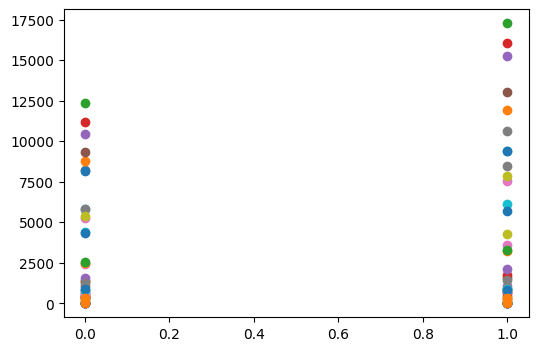

In [3]:
d.plot('spb', './', '7-01-2018', '6-20-2019')

In [ ]:
epid, simulation_func, data = d.calibrate('spb', './', '7-01-2018', '6-20-2019')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

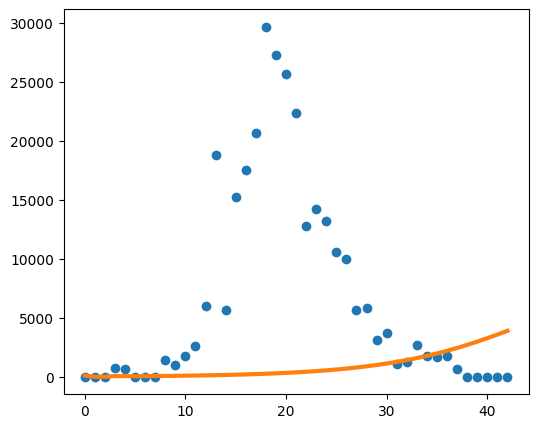

In [4]:

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
start_day = 15    
posterior = epid.posterior.stack(samples=("draw", "chain"))
ax.plot(list(data), "o")
ax.plot(simulation_func(None, posterior["alpha"].mean(), posterior["beta"].mean()), 
                linewidth=3)


In [3]:
from model_complex import FactoryBRModel

BRModel = FactoryBRModel.get_model('age-group')

Exception: model: ag-group does not exist

In [2]:
BRModel.simulate([1,1], [1,1])

TypeError: AgeGroupBRModel.simulate() missing 4 required positional arguments: 'alpha', 'beta', 'initial_infectious', and 'rho'